<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/notebooks/hfe_two_endpoints_one_local_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!sudo apt-get update
!sudo apt-get install git-lfs
!pip install --upgrade pip
!pip install huggingface-hub

In [ ]:
!pip install -U tensorflow
!pip install keras-cv

In [ ]:
# setup cli with token
!huggingface-cli login
!git config --global credential.helper store

In [ ]:
!git lfs install
!git config --global user.email "deep.diver.csp@gmail.com"
!git config --global user.name "Chansung Park"

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log


In [ ]:
import json

def is_jsonable(x):
    try:
        json.dumps(x)
        return True
    except (TypeError, OverflowError):
        return False

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [ ]:
import requests
import PIL

from io import BytesIO

def download_image(url, mode="RGB"):
  response = requests.get(url)
  return PIL.Image.open(BytesIO(response.content)).convert(mode)

# Encoder

In [ ]:
BATCH_SIZE = 4

In [ ]:
REPO_ID = "keras-sd/text-encoder"

In [ ]:
!git clone https://huggingface.co/{REPO_ID}

Cloning into 'text-encoder'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 42 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), 7.72 KiB | 718.00 KiB/s, done.


In [ ]:
%cd /content/

[Errno 2] No such file or directory: '/content/'
/home


In [ ]:
import importlib 

handler = importlib.import_module("text-encoder.handler")

my_handler = handler.EndpointHandler(path=".")

payload = {"inputs": "Face of a yellow cat, high resolution, sitting on a park bench",
           "batch_size": BATCH_SIZE}

response = my_handler(payload)

2022-12-20 05:24:38.599039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 05:24:39.378898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-20 05:24:39.379019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras

1356917/1356917 [==============================] - 0s 0us/step


2022-12-20 05:24:43.207772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 05:24:43.813889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38249 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


492466864/492466864 [==============================] - 10s 0us/step


2022-12-20 05:25:01.797972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


# Inpainting Diffusion Model

In [ ]:
REPO_ID = "keras-sd/inpaint-diffusion-model"

In [ ]:
!git clone https://huggingface.co/{REPO_ID}

Cloning into 'inpaint-diffusion-model'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 486 bytes | 486.00 KiB/s, done.


In [ ]:
%cd /content/inpaint-diffusion-model

/home/inpaint-diffusion-model


In [ ]:
!echo "keras-cv" >> requirements.txt
!echo "tensorflow" >> requirements.txt
!echo "tensorflow_datasets" >> requirements.txt

In [ ]:
%%writefile handler.py
from typing import Dict, List, Any
import base64

import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_cv.models.generative.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.models.generative.stable_diffusion.diffusion_model import DiffusionModel

class GroupNormalization(tf.keras.layers.Layer):
    """GroupNormalization layer.
    This layer is only here temporarily and will be removed
    as we introduce GroupNormalization in core Keras.
    """

    def __init__(
        self,
        groups=32,
        axis=-1,
        epsilon=1e-5,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        self.gamma = self.add_weight(
            shape=(dim,),
            name="gamma",
            initializer="ones",
        )
        self.beta = self.add_weight(
            shape=(dim,),
            name="beta",
            initializer="zeros",
        )

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        reshaped_inputs = self._reshape_into_groups(inputs, input_shape)
        normalized_inputs = self._apply_normalization(reshaped_inputs, input_shape)
        return tf.reshape(normalized_inputs, input_shape)

    def _reshape_into_groups(self, inputs, input_shape):
        group_shape = [input_shape[i] for i in range(inputs.shape.rank)]
        group_shape[self.axis] = input_shape[self.axis] // self.groups
        group_shape.insert(self.axis, self.groups)
        group_shape = tf.stack(group_shape)
        return tf.reshape(inputs, group_shape)

    def _apply_normalization(self, reshaped_inputs, input_shape):
        group_reduction_axes = list(range(1, reshaped_inputs.shape.rank))
        axis = -2 if self.axis == -1 else self.axis - 1
        group_reduction_axes.pop(axis)
        mean, variance = tf.nn.moments(
            reshaped_inputs, group_reduction_axes, keepdims=True
        )
        gamma, beta = self._get_reshaped_weights(input_shape)
        return tf.nn.batch_normalization(
            reshaped_inputs,
            mean=mean,
            variance=variance,
            scale=gamma,
            offset=beta,
            variance_epsilon=self.epsilon,
        )

    def _get_reshaped_weights(self, input_shape):
        broadcast_shape = self._create_broadcast_shape(input_shape)
        gamma = tf.reshape(self.gamma, broadcast_shape)
        beta = tf.reshape(self.beta, broadcast_shape)
        return gamma, beta

    def _create_broadcast_shape(self, input_shape):
        broadcast_shape = [1] * input_shape.shape.rank
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(self.axis, self.groups)
        return broadcast_shape

class PaddedConv2D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding=0, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.padding2d = keras.layers.ZeroPadding2D(padding)
        self.conv2d = keras.layers.Conv2D(filters, kernel_size, strides=strides)

    def call(self, inputs):
        x = self.padding2d(inputs)
        return self.conv2d(x)        

class AttentionBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.norm = GroupNormalization(epsilon=1e-5)
        self.q = PaddedConv2D(output_dim, 1)
        self.k = PaddedConv2D(output_dim, 1)
        self.v = PaddedConv2D(output_dim, 1)
        self.proj_out = PaddedConv2D(output_dim, 1)

    def call(self, inputs):
        x = self.norm(inputs)
        q, k, v = self.q(x), self.k(x), self.v(x)

        # Compute attention
        _, h, w, c = q.shape
        q = tf.reshape(q, (-1, h * w, c))  # b, hw, c
        k = tf.transpose(k, (0, 3, 1, 2))
        k = tf.reshape(k, (-1, c, h * w))  # b, c, hw
        y = q @ k
        y = y * (c**-0.5)
        y = keras.activations.softmax(y)

        # Attend to values
        v = tf.transpose(v, (0, 3, 1, 2))
        v = tf.reshape(v, (-1, c, h * w))
        y = tf.transpose(y, (0, 2, 1))
        x = v @ y
        x = tf.transpose(x, (0, 2, 1))
        x = tf.reshape(x, (-1, h, w, c))
        return self.proj_out(x) + inputs

class ResnetBlock(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.norm1 = GroupNormalization(epsilon=1e-5)
        self.conv1 = PaddedConv2D(output_dim, 3, padding=1)
        self.norm2 = GroupNormalization(epsilon=1e-5)
        self.conv2 = PaddedConv2D(output_dim, 3, padding=1)

    def build(self, input_shape):
        if input_shape[-1] != self.output_dim:
            self.residual_projection = PaddedConv2D(self.output_dim, 1)
        else:
            self.residual_projection = lambda x: x

    def call(self, inputs):
        x = self.conv1(keras.activations.swish(self.norm1(inputs)))
        x = self.conv2(keras.activations.swish(self.norm2(x)))
        return x + self.residual_projection(inputs)

class ImageEncoder(keras.Sequential):
    """ImageEncoder is the VAE Encoder for StableDiffusion."""

    def __init__(self, img_height=512, img_width=512, download_weights=True):
        super().__init__(
            [
                keras.layers.Input((img_height, img_width, 3)),
                PaddedConv2D(128, 3, padding=1),
                ResnetBlock(128),
                ResnetBlock(128),
                PaddedConv2D(128, 3, padding=1, strides=2),
                ResnetBlock(256),
                ResnetBlock(256),
                PaddedConv2D(256, 3, padding=1, strides=2),
                ResnetBlock(512),
                ResnetBlock(512),
                PaddedConv2D(512, 3, padding=1, strides=2),
                ResnetBlock(512),
                ResnetBlock(512),
                ResnetBlock(512),
                AttentionBlock(512),
                ResnetBlock(512),
                GroupNormalization(epsilon=1e-5),
                keras.layers.Activation("swish"),
                PaddedConv2D(8, 3, padding=1),
                PaddedConv2D(8, 1),
                # TODO(lukewood): can this be refactored to be a Rescaling layer?
                # Perhaps some sort of rescale and gather?
                # Either way, we may need a lambda to gather the first 4 dimensions.
                keras.layers.Lambda(lambda x: x[..., :4] * 0.18215),
            ]
        )

        if download_weights:
            image_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/vae_encoder.h5",
                file_hash="c60fb220a40d090e0f86a6ab4c312d113e115c87c40ff75d11ffcf380aab7ebb",
            )
            self.load_weights(image_encoder_weights_fpath)

class EndpointHandler():
    def __init__(self, path=""):
        self.seed = None

        img_height = 512
        img_width = 512
        self.img_height = round(img_height / 128) * 128
        self.img_width = round(img_width / 128) * 128        

        self.MAX_PROMPT_LENGTH = 77
        self.diffusion_model = DiffusionModel(self.img_height, self.img_width, self.MAX_PROMPT_LENGTH)
        diffusion_model_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_diffusion_model.h5",
            file_hash="8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe",
        )
        self.diffusion_model.load_weights(diffusion_model_weights_fpath)     

        self.image_encoder = ImageEncoder()

    def _get_initial_diffusion_noise(self, batch_size, seed):
        if seed is not None:
            return tf.random.stateless_normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4),
                seed=[seed, seed],
            )
        else:
            return tf.random.normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4)
            )

    def _get_initial_alphas(self, timesteps):
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_timestep_embedding(self, timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        freqs = tf.math.exp(
            -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    def _prepare_img_mask(self, image, mask, batch_size):
        image = base64.b64decode(image)
        image = np.frombuffer(image, dtype="uint8")
        image = np.reshape(image, (512, 512, 3))
        image = tf.convert_to_tensor(image)

        image = tf.squeeze(image)
        image = tf.cast(image, dtype=tf.float32) / 255.0 * 2.0 - 1.0
        image = tf.expand_dims(image, axis=0)
        known_x0 = self.image_encoder(image)
        if image.shape.rank == 3:
            known_x0 = tf.repeat(known_x0, batch_size, axis=0)

        mask = base64.b64decode(mask)
        mask = np.frombuffer(mask, dtype="uint8")
        mask = np.reshape(mask, (512, 512, 1))
        mask = tf.convert_to_tensor(mask)

        mask = tf.expand_dims(mask, axis=0)
        mask = tf.cast(
            tf.nn.max_pool2d(mask, ksize=8, strides=8, padding="SAME"),
            dtype=tf.float32,
        )
        mask = tf.squeeze(mask)
        if mask.shape.rank == 2:
            mask = tf.repeat(tf.expand_dims(mask, axis=0), batch_size, axis=0)
        mask = tf.expand_dims(mask, axis=-1)

        return known_x0, mask

    def __call__(self, data: Dict[str, Any]) -> str:
        # get inputs 
        inputs = data.pop("inputs", data)
        batch_size = data.pop("batch_size", 1)

        context = base64.b64decode(inputs[0])
        context = np.frombuffer(context, dtype="float32")
        context = np.reshape(context, (batch_size, 77, 768))

        unconditional_context = base64.b64decode(inputs[1])
        unconditional_context = np.frombuffer(unconditional_context, dtype="float32")
        unconditional_context = np.reshape(unconditional_context, (batch_size, 77, 768))

        num_steps = data.pop("num_steps", 25)
        unconditional_guidance_scale = data.pop("unconditional_guidance_scale", 7.5)
        num_resamples = data.pop("num_resamples", 1)

        known_x0, mask = self._prepare_img_mask(inputs[2], inputs[3], batch_size)

        latent = self._get_initial_diffusion_noise(batch_size, self.seed)

        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0

        for index, timestep in list(enumerate(timesteps))[::-1]:
            a_t, a_prev = alphas[index], alphas_prev[index]
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)

            for resample_index in range(num_resamples):
                unconditional_latent = self.diffusion_model.predict_on_batch(
                    [latent, t_emb, unconditional_context]
                )
                latent = self.diffusion_model.predict_on_batch([latent, t_emb, context])
                latent = unconditional_latent + unconditional_guidance_scale * (
                    latent - unconditional_latent
                )
                pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
                latent = latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0

                # Use known image (x0) to compute latent
                if timestep > 1:
                    noise = tf.random.normal(tf.shape(known_x0), seed=self.seed)
                else:
                    noise = 0.0
                known_latent = (
                    math.sqrt(a_prev) * known_x0 + math.sqrt(1 - a_prev) * noise
                )
                # Use known latent in unmasked regions
                latent = mask * known_latent + (1 - mask) * latent
                # Resample latent
                if resample_index < num_resamples - 1 and timestep > 1:
                    beta_prev = 1 - (a_t / a_prev)
                    latent_prev = tf.random.normal(
                        tf.shape(latent),
                        mean=latent * math.sqrt(1 - beta_prev),
                        stddev=math.sqrt(beta_prev),
                        seed=self.seed,
                    )

            iteration += 1
            progbar.update(iteration)

        latent_b64 = base64.b64encode(latent.numpy().tobytes())
        latent_b64str = latent_b64.decode()

        return latent_b64str            

Overwriting handler.py


In [ ]:
img_url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

In [ ]:
import base64
import numpy as np

img_height = 512
img_width = 512
img_height = round(img_height / 128) * 128
img_width = round(img_width / 128) * 128

image = download_image(img_url).resize((512, 512))
mask = download_image(mask_url, mode="L").resize((512, 512))

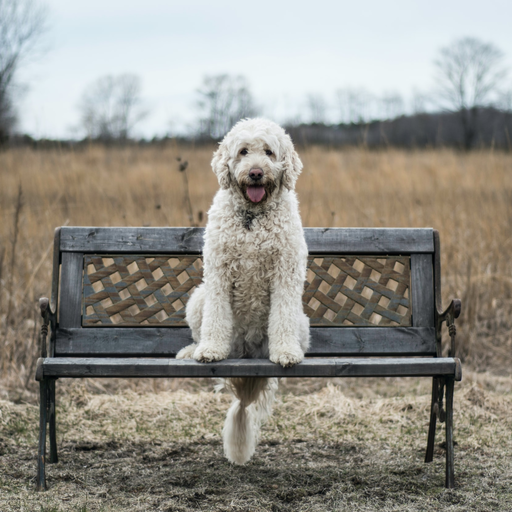

In [ ]:
image

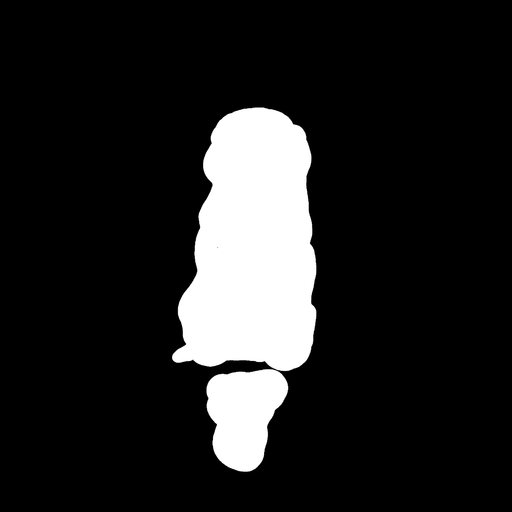

In [ ]:
mask

In [ ]:
mask = np.asarray(mask)
mask = np.where(mask < 255, 1, mask)
mask = np.where(mask == 255, 0, mask)

image_b64 = base64.b64encode(image.tobytes())
image_b64str = image_b64.decode()

mask_b64 = base64.b64encode(mask.tobytes())
mask_b64str = mask_b64.decode()

In [ ]:
%cd /content/

/home


In [ ]:
import importlib

handler = importlib.import_module("inpaint-diffusion-model.handler")
# latent = response

# init pipeline
my_handler = handler.EndpointHandler(path=".")

# prepare sample playoad
payload = {"inputs": [response["context_b64str"], response["unconditional_context_b64str"], image_b64str, mask_b64str],
           "batch_size": BATCH_SIZE}

# test the pipeline
response = my_handler(payload)

25/25 [==============================] - 17s 401ms/step


In [ ]:
is_jsonable(response)

True

In [ ]:
%cd /content/inpaint-diffusion-model

/home/inpaint-diffusion-model


In [ ]:
!git add * 
!git commit -m "add custom handler"
!git push

[main aae13dc] add custom handler
 3 files changed, 334 insertions(+)
 create mode 100644 __pycache__/handler.cpython-38.pyc
 create mode 100644 handler.py
 create mode 100644 requirements.txt
Username for 'https://huggingface.co': ^C


# Decoder

In [ ]:
%cd /content/

/home


In [ ]:
REPO_ID = "keras-sd/decoder"

In [ ]:
!git clone https://huggingface.co/{REPO_ID}

Cloning into 'decoder'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), 5.13 KiB | 656.00 KiB/s, done.


In [ ]:
import importlib

handler = importlib.import_module("decoder.handler")
# latent = response

# init pipeline
my_handler = handler.EndpointHandler(path=".")

# prepare sample playoad
payload = {"inputs": response,
           "batch_size": BATCH_SIZE}

# test the pipeline
response = my_handler(payload)

198180272/198180272 [==============================] - 4s 0us/step


In [ ]:
import base64
import numpy as np

images = base64.b64decode(response)
images = np.frombuffer(images, dtype="uint8")
images = np.reshape(images, (BATCH_SIZE, 512, 512, 3))

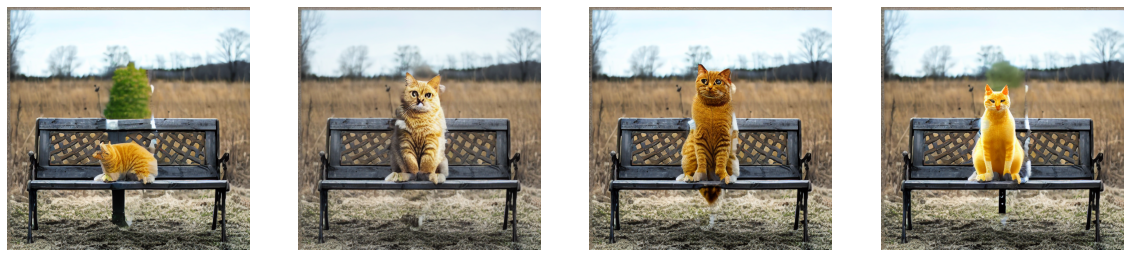

In [ ]:
plot_images(images)